# DES Y6 Deep Field Exposures:  Photometric Zeropoints tied to SDSS DR13 (QA)

## 1. Setup

In [59]:
import numpy as np
import pandas as pd
from scipy import interpolate
import glob
import math
import os
import subprocess
import sys
import gc

import glob
import pickle

import easyaccess as ea

#import AlasBabylon

import fitsio
from astropy.io import fits
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table, vstack

import tempfile

import matplotlib.pyplot as plt
 
%matplotlib inline

In [60]:
# Useful class to stop "Run All" at a cell 
#  containing the command "raise StopExecution"
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

## 2. User Input

### 2.1.  General User Input  

In [78]:
verbose = 1
tag_des = 'Y6A2_FINALCUT'      # Official tag for DES Y6A2_FINALCUT
tag_decade = 'DECADE_FINALCUT' # Tag for DECADE
rawdata_dir = '../RawData'
zeropoints_dir='../Zeropoints'
qa_dir = '../QA'

#bandList = ['u', 'g', 'r', 'i', 'z']   # Oops!  Missing transformation eqn for Y-band...
bandList = ['u', 'g', 'r', 'i', 'z']
#bandList = ['g']

## Dictionary of DES bands on which to run the transform fit...
#desBand_dict = {'u':'u_des', 'g':'g_des', 'r':'r_des', 'i':'i_des', 'z':'z_des'}
#
## Dictionary of corresponding bands from the other survey...
#matchBand_dict = {'u':'u_sdss', 'g':'g_sdss', 'r':'r_sdss', 'i':'i_sdss', 'z':'z_sdss'}
## Dictionary of corresponding colors from the other survey...
#color_name_1_dict = {'u':'gr_sdss', 'g':'gi_sdss', 'r':'ri_sdss', 'i':'ri_sdss', 'z':'ri_des'}
## Name of color_name_1 as the label in the QA plots...
#colorLabel_1_dict = {'u':'$(g-r)_{sdss}$', 'g':'$(g-i)_{sdss}$', 'r':'$(r-i)_{sdss}$', 'i':'$(r-i)_{sdss}$', 'z':'$(r-i)_{sdss}$'}
## Color limits defining disjoint branches of the dmag vs. color plots...
#color_limits_1_dict = {'u_des':[+0.2,1.4],
#                       'g_des':[-1.0,3.5], 
#                       'r_des':[-0.4,2.0], 
#                       'i_des':[-0.4,2.0],
#                       'z_des':[-0.4,2.0]}


### 2.2. Logical Variables to Indicate which Code Cells to Run

In [62]:
do_qa_sdss_zps = True

### 2.3. Sky Region Definitions

In [63]:
region_name_list = [
                    'VVDSF14', 
                    'VVDSF22', 
                    'DEEP2', 
                    'SN-E', 
                    'SN-X_err', 
                    'SN-X', 
                    'ALHAMBRA2', 
                    'SN-S',
                    'SN-C', 
                    'EDFS',
                    'MACS0416',
                    'SN-S_err',
                    'COSMOS'
                    ]

region_ramin = {
                'VVDSF14':208.,
                'VVDSF22':333.,
                'DEEP2':351., 
                'SN-E':6., 
                'SN-X_err':13., 
                'SN-X':32., 
                'ALHAMBRA2':35., 
                'SN-S':39.5,
                'SN-C':50., 
                'EDFS':55.,
                'MACS0416':62.,
                'SN-S_err':83.5,
                'COSMOS':148.
               }

region_ramax = {
                'VVDSF14':212.,
                'VVDSF22':337.,
                'DEEP2':354., 
                'SN-E':12., 
                'SN-X_err':17., 
                'SN-X':38., 
                'ALHAMBRA2':39., 
                'SN-S':44.5,
                'SN-C':56., 
                'EDFS':67.,
                'MACS0416':66.,
                'SN-S_err':88.,
                'COSMOS':153.
               }

region_decmin = {
                'VVDSF14':3.,
                'VVDSF22':-1.5,
                'DEEP2':-1.5, 
                'SN-E':-46., 
                'SN-X_err':-32., 
                'SN-X':-8., 
                'ALHAMBRA2':-0.5, 
                'SN-S':-2.5,
                'SN-C':-31., 
                'EDFS':-51.,
                'MACS0416':-25.5,
                'SN-S_err':-38.,
                'COSMOS':0.5
               }


region_decmax = {
                'VVDSF14':7.,
                'VVDSF22':1.5,
                'DEEP2':1.5, 
                'SN-E':-41., 
                'SN-X_err':-29., 
                'SN-X':-3., 
                'ALHAMBRA2':2.5, 
                'SN-S':1.5,
                'SN-C':-25., 
                'EDFS':-46.,
                'MACS0416':-22.5,
                'SN-S_err':-35.,
                'COSMOS':4.0
               }


for regionName in region_name_list:
    print regionName, region_ramin[regionName], region_ramax[regionName], region_decmin[regionName], region_decmax[regionName]

VVDSF14 208.0 212.0 3.0 7.0
VVDSF22 333.0 337.0 -1.5 1.5
DEEP2 351.0 354.0 -1.5 1.5
SN-E 6.0 12.0 -46.0 -41.0
SN-X_err 13.0 17.0 -32.0 -29.0
SN-X 32.0 38.0 -8.0 -3.0
ALHAMBRA2 35.0 39.0 -0.5 2.5
SN-S 39.5 44.5 -2.5 1.5
SN-C 50.0 56.0 -31.0 -25.0
EDFS 55.0 67.0 -51.0 -46.0
MACS0416 62.0 66.0 -25.5 -22.5
SN-S_err 83.5 88.0 -38.0 -35.0
COSMOS 148.0 153.0 0.5 4.0


### 2.4. Check on Location of TMPDIR...

In [64]:
# Check on TMPDIR... 
tempfile.gettempdir()

'/data/des40.a/data/dtucker/TmpDir'

In [65]:
# Set tmpdir variable to $TMPDIR (for future reference)...
tmpdir = os.environ['TMPDIR']

### 2.5. Create Main QA Directory (if it does not already exist)...

In [66]:
# Create main QA directory, if it does not already exist...
if not os.path.exists(qa_dir):
    os.makedirs(qa_dir)

## 3. Useful Modules

In [67]:
def sdssQAPlots(df, title, plotText, dmagName, colorLabel1, outputFileName):

    
    dmag = df['MAG_DIFF']
    res = df['MAG_DIFF']
    color1 = df['psfMag_g'] - df['psfMag_r']
    title = 'Title'
    plotText = 'Plot Text'
    dmagName = """%s_std-%s_obs""" % (band, band)
    colorLabel1 = colorLabel_1_dict[band]
    outputFileName = 'test.png'
    
    # Prepare QA plots...
    fig = plt.figure(figsize=(20,10))
    fig.subplots_adjust(hspace=0.3)
    #fig.suptitle("This is a supertitle!")
    plt.rcParams.update({'font.size': 24})

    
    # We will exclude the lowest and highest 0.01% of color1,  
    #  dmag, and residuals when plotting the QA figures...
    color1_desc = color1.describe(percentiles=[0.0001, 0.001, 0.01, 0.05, 0.95, 0.99, 0.999, 0.9999])
    dmag_desc = dmag.describe(percentiles=[0.0001, 0.001, 0.01, 0.05, 0.95, 0.99, 0.999, 0.9999])
    res_desc = res.describe(percentiles=[0.0001, 0.001, 0.01, 0.05, 0.95, 0.99, 0.999, 0.9999])
    #color1_min = color1_desc['0.01%']
    #color1_max = color1_desc['99.99%']
    #dmag_min = dmag_desc['0.01%']
    #dmag_max = dmag_desc['99.99%']
    #res_min = res_desc['0.01%']
    #res_max = res_desc['99.99%']
    color1_min = color1_desc['1%']
    color1_max = color1_desc['99%']
    dmag_min = dmag_desc['5%']
    dmag_max = dmag_desc['95%']
    res_min = res_desc['5%']
    res_max = res_desc['95%']

    # What the heck; let's just set this to -0.10 mag --> +0.10 mag...
    #res_min = -0.10
    #res_max = +0.10

    mask =  ( (df['MAG_DIFF'] >= res_min)  & (df['MAG_DIFF'] < res_max) )
    mask &= ( (df['MAG_DIFF'] >= dmag_min) & (df['MAG_DIFF'] < dmag_max) )
    mask &= ( (df['psfMag_g']-df['psfMag_r'] >= color1_min) & (df['psfMag_g']-df['psfMag_r'] < color1_max) )
    mask &= ( (df['psfMag_g'] >= 14.) & (df['psfMag_g'] < 25.) )

    df1 = df[mask]
    dmag = df1['MAG_DIFF']
    res = df1['MAG_DIFF']
    color1 = df1['psfMag_g'] - df1['psfMag_r']
    
    
    # Plot 1:  Descriptive text...
    #plt.subplot(231)
    plt.subplot(221)
    plt.text(0.1,0.80,title,fontsize=24)
    plt.text(0.00,0.40,plotText,fontsize=12)
    plt.axis('off')

    
    # Plot 2:  2D hexbin histogram of dmag vs. color1...
    #plt.subplot(232) 
    plt.subplot(222)
    hb=plt.hexbin(color1, dmag, gridsize=100, bins='log', cmap='inferno')
    plt.axis([color1_min, color1_max, dmag_min, dmag_max])
    plt.xlabel(colorLabel1)
    plt.ylabel(dmagName)
    cb = fig.colorbar(hb)
    #cb.set_label('Number')
    cb.set_label('log10(N)')
    plt.grid(color='white')
    plt.grid(True)


    # Plot 3:  1d histogram of residuals...
    #plt.subplot(234) 
    plt.subplot(223) 
    #plt.hist(df.loc[:,'res'],bins=100)
    plt.hist(res,bins=100)
    plt.xlabel('residuals [mag]')
    plt.ylabel('Number')
    plt.grid(True)
    plt.grid(color='black')

    
    # Plot 4:  2d hexbin histogram of residuals vs. mag...
    #plt.subplot(235) 
    plt.subplot(224) 
    #hb = plt.hexbin(color1, df.loc[:,'res'], gridsize=100, cmap='inferno')
    hb = plt.hexbin(df1.loc[:,'psfMag_g'], res, gridsize=100, bins='log', cmap='inferno')
    plt.axis([14.0, 25.0, res_min, res_max])
    plt.xlabel(colorLabel1)
    plt.ylabel('residuals [mag]')
    cb = plt.colorbar(hb)
    #cb.set_label('Number')
    cb.set_label('log10(N)')
    plt.grid(True)
    plt.grid(color='white')

    
    # Plot...
    plt.tight_layout()
    #plt.show()
    plt.savefig(outputFileName)

    return 0


In [68]:
# Transform SDSS mags into DES mags for this filter band...
def transSDSStoDES(dataFrame, band, magStdColName, magerrStdColName):

    import numpy as np 
    import pandas as pd
    from collections import OrderedDict as odict

    # Transformation coefficients (updated based on fit to DES).
    # mag_des = mag_sdss + A[mag][0]*color_sdss + A[mag][1]
    # (based on A. Drlica-Wagner's https://github.com/kadrlica/desqr/blob/master/desqr/calibrate.py).
    # Values come from DES-doc#9420 (u-band) and the DES DR2 paper (g-,r-,i-,z-bands).
    SDSS = odict([
            ('u', [-0.350, +0.466, -0.479, ]), # [+0.2 < (g-r)_sdss <= 1.4]
            ('g', [-0.061, +0.008]), # [-1.0 < (g-i)_sdss <= 3.5]
            ('r', [-0.155, -0.007]), # [-0.4 < (r-i)_sdss <= 2.0]
            ('i', [-0.166, +0.032]), # [-0.4 < (r-i)_sdss <= 2.0]
            ('z', [-0.056, +0.027]), # [-0.4 < (r-i)_sdss <= 2.0]
            ]) 
    
    A = SDSS

    if band is 'u':
        # u_des = u_sdss - 0.350*(g-r)_sdss**2 + 0.466*(g-r)_sdss - 0.479    [+0.2 < (g-r)_sdss <= 1.4]
        dataFrame[magStdColName] = dataFrame['psfMag_u']+\
            A[band][0]*(dataFrame['psfMag_g']-dataFrame['psfMag_r'])*(dataFrame['psfMag_g']-dataFrame['psfMag_r'])+\
            A[band][1]*(dataFrame['psfMag_g']-dataFrame['psfMag_r'])+\
            A[band][2]
        dataFrame[magerrStdColName] = dataFrame['psfMagErr_u']  # temporary
        mask  = ( (dataFrame['psfMag_g']-dataFrame['psfMag_r']) > +0.2)
        mask &= ( (dataFrame['psfMag_g']-dataFrame['psfMag_r']) <= 1.4)
    elif band is 'g':
        # g_des = g_sdss - 0.061*(g-i)_sdss + 0.008   [-1.0 < (g-i)_sdss <= 3.5]
        dataFrame[magStdColName] = dataFrame['psfMag_g']+\
            A[band][0]*(dataFrame['psfMag_g']-dataFrame['psfMag_i'])+A[band][1]
        dataFrame[magerrStdColName] = dataFrame['psfMagErr_g']  # temporary
        mask  = ( (dataFrame['psfMag_g']-dataFrame['psfMag_i']) > -1.0)
        mask &= ( (dataFrame['psfMag_g']-dataFrame['psfMag_i']) <= 3.5)
    elif band is 'r':
        # r_des = r_sdss - 0.155*(r-i)_sdss - 0.007   [-0.4 < (r-i)_sdss <= 2.0]
        dataFrame[magStdColName] = dataFrame['psfMag_r']+\
            A[band][0]*(dataFrame['psfMag_r']-dataFrame['psfMag_i'])+A[band][1]
        dataFrame[magerrStdColName] = dataFrame['psfMagErr_r']  # temporary
        mask  = ( (dataFrame['psfMag_r']-dataFrame['psfMag_i']) > -0.4)
        mask &= ( (dataFrame['psfMag_r']-dataFrame['psfMag_i']) <= 2.0)
    elif band is 'i':
        # i_des = i_sdss - 0.166*(r-i)_sdss + 0.032   [-0.4 < (r-i)_sdss <= 2.0]
        dataFrame[magStdColName] = dataFrame['psfMag_i']+\
            A[band][0]*(dataFrame['psfMag_r']-dataFrame['psfMag_i'])+A[band][1]
        dataFrame[magerrStdColName] = dataFrame['psfMagErr_i']  # temporary
        mask  = ( (dataFrame['psfMag_r']-dataFrame['psfMag_i']) > -0.4)
        mask &= ( (dataFrame['psfMag_r']-dataFrame['psfMag_i']) <= 2.0)
    elif band is 'z':
        # z_des = z_sdss - 0.056*(r-i)_sdss + 0.027   [-0.4 < (r-i)_sdss <= 2.0]
        dataFrame[magStdColName] = dataFrame['psfMag_z']+\
            A[band][0]*(dataFrame['psfMag_r']-dataFrame['psfMag_i'])+A[band][1]
        dataFrame[magerrStdColName] = dataFrame['psfMagErr_z']  # temporary
        mask  = ( (dataFrame['psfMag_r']-dataFrame['psfMag_i']) > -0.4)
        mask &= ( (dataFrame['psfMag_r']-dataFrame['psfMag_i']) <= 2.0)
    else:
        msg = "Unrecognized band: %s "%band
        raise ValueError(msg)

    dataFrame = dataFrame[mask].copy()

    return dataFrame

## 4. Read in Zeropoint Tables

**We will first work with the DES data, and then we will repeat for the DECADE data.**

**DES:**

In [97]:
if do_qa_sdss_zps:
        
    subdir = """DES_%s""" % (tag_des)
    tmpdir = os.environ['TMPDIR']
    
    df_zp_collection = {}

    for band in bandList:
        
        zpFile = """zps_%s.%s.sdss.csv""" % (subdir, band)
        zpFile = os.path.join(zeropoints_dir, zpFile)
        df_zp = pd.read_csv(zpFile, usecols=['FILENAME','EXPNUM_MEDIAN','CCDNUM_MEDIAN',
                                         'MAG_ZERO_MEAN','MAG_ZERO_MEAN_ERR','MAG_ZERO_NUM',
                                         'AIRMASS_MEDIAN','EXPTIME_MEDIAN',
                                         'RA_CENT_MEDIAN','DEC_CENT_MEDIAN','MJD_OBS_MEDIAN'])

        # Rename '_MEDIAN' columns...
        #  (The '_MEDIAN' suffix is a 'feature' of how the zeropoints table was created.)
        df_zp.rename(columns={'EXPNUM_MEDIAN':'EXPNUM',
                              'CCDNUM_MEDIAN':'CCDNUM',
                              'AIRMASS_MEDIAN':'AIRMASS', 
                              'EXPTIME_MEDIAN':'EXPTIME', 
                              'RA_CENT_MEDIAN':'RA_CENT', 
                              'DEC_CENT_MEDIAN':'DEC_CENT',
                              'MJD_OBS_MEDIAN':'MJD_OBS'
                            },inplace=True)

        # Likewise, convert EXPNUM, CCDNUM, and MAG_ZERO_NUM from floats to ints...
        #  (Again, a 'feature' of how the zeropoints table was created.)
        df_zp['EXPNUM'] = df_zp['EXPNUM'].astype(int)
        df_zp['CCDNUM'] = df_zp['CCDNUM'].astype(int)
        df_zp['MAG_ZERO_NUM'] = df_zp['MAG_ZERO_NUM'].astype(int)

        # Add df_zp the df_zp_collection_des dictionary...
        df_zp_collection[band] = df_zp

    # df_zp_collection specifically for the DES data...
    df_zp_collection_des = df_zp_collection

In [100]:
# Let's look at one of the zeropoint tables...
df_zp = df_zp_collection_des['g']
df_zp.head(5)

,AIRMASS,CCDNUM,DEC_CENT,EXPNUM,EXPTIME,FILENAME,MAG_ZERO_MEAN,MAG_ZERO_MEAN_ERR,MAG_ZERO_NUM,MJD_OBS,RA_CENT
0,1.18,1,1.8057,573106,90.0,D00573106_g_c01_r3624p01_red-fullcat.fits,31.5385,0.0034,29,57641.3113,36.9081
1,1.18,3,1.8055,573106,90.0,D00573106_g_c03_r3624p01_red-fullcat.fits,31.5246,0.0040,58,57641.3113,37.5294
2,1.18,4,1.6416,573106,90.0,D00573106_g_c04_r3624p01_red-fullcat.fits,31.5024,0.0051,40,57641.3113,36.7526
3,1.18,5,1.6420,573106,90.0,D00573106_g_c05_r3624p01_red-fullcat.fits,31.5203,0.0035,39,57641.3113,37.0633
4,1.18,6,1.6418,573106,90.0,D00573106_g_c06_r3624p01_red-fullcat.fits,31.5133,0.0066,35,57641.3113,37.3741


**DECADE:**

In [116]:
if do_qa_sdss_zps:
        
    subdir = """%s""" % (tag_decade)
    tmpdir = os.environ['TMPDIR']
    
    df_zp_collection = {}

    for band in bandList:
        
        zpFile = """zps_%s.%s.sdss.csv""" % (subdir, band)
        zpFile = os.path.join(zeropoints_dir, zpFile)
        df_zp = pd.read_csv(zpFile, usecols=['FILENAME','EXPNUM_MEDIAN','CCDNUM_MEDIAN',
                                         'MAG_ZERO_MEAN','MAG_ZERO_MEAN_ERR','MAG_ZERO_NUM',
                                         'AIRMASS_MEDIAN','EXPTIME_MEDIAN',
                                         'RA_CENT_MEDIAN','DEC_CENT_MEDIAN','MJD_OBS_MEDIAN'])

        # Rename '_MEDIAN' columns...
        #  (The '_MEDIAN' suffix is a 'feature' of how the zeropoints table was created.)
        df_zp.rename(columns={'EXPNUM_MEDIAN':'EXPNUM',
                              'CCDNUM_MEDIAN':'CCDNUM',
                              'AIRMASS_MEDIAN':'AIRMASS', 
                              'EXPTIME_MEDIAN':'EXPTIME', 
                              'RA_CENT_MEDIAN':'RA_CENT', 
                              'DEC_CENT_MEDIAN':'DEC_CENT',
                              'MJD_OBS_MEDIAN':'MJD_OBS'
                            },inplace=True)

        # Likewise, convert EXPNUM, CCDNUM, and MAG_ZERO_NUM from floats to ints...
        #  (Again, a 'feature' of how the zeropoints table was created.)
        df_zp['EXPNUM'] = df_zp['EXPNUM'].astype(int)
        df_zp['CCDNUM'] = df_zp['CCDNUM'].astype(int)
        df_zp['MAG_ZERO_NUM'] = df_zp['MAG_ZERO_NUM'].astype(int)

        # Add df_zp the df_zp_collection_des dictionary...
        df_zp_collection[band] = df_zp

    # df_zp_collection specifically for the DECADE data...
    df_zp_collection_decade = df_zp_collection

In [117]:
# Let's look at one of the zeropoint tables...
df_zp = df_zp_collection_decade['g']
df_zp.head(5)

,AIRMASS,CCDNUM,DEC_CENT,EXPNUM,EXPTIME,FILENAME,MAG_ZERO_MEAN,MAG_ZERO_MEAN_ERR,MAG_ZERO_NUM,MJD_OBS,RA_CENT
0,1.35,1,3.1061,743018,130.0,D00743018_g_c01_r5542p01_red-fullcat.fits,31.6955,0.0036,33,58244.073,149.8090
1,1.35,2,3.1059,743018,130.0,D00743018_g_c02_r5542p01_red-fullcat.fits,31.6711,0.0027,36,58244.073,150.1198
2,1.35,3,3.1060,743018,130.0,D00743018_g_c03_r5542p01_red-fullcat.fits,31.6859,0.0043,56,58244.073,150.4309
3,1.35,4,2.9419,743018,130.0,D00743018_g_c04_r5542p01_red-fullcat.fits,31.6875,0.0037,35,58244.073,149.6535
4,1.35,5,2.9424,743018,130.0,D00743018_g_c05_r5542p01_red-fullcat.fits,31.6912,0.0027,33,58244.073,149.9644


## 4. Create Some QA plots for the Zeropoint Tables

**We will first work with the DES data, and then we will repeat for the DECADE data.**

**DES:**

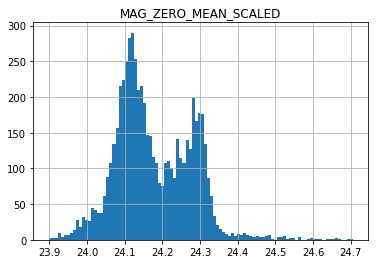

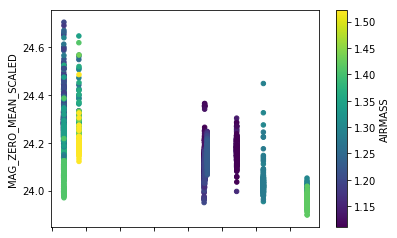

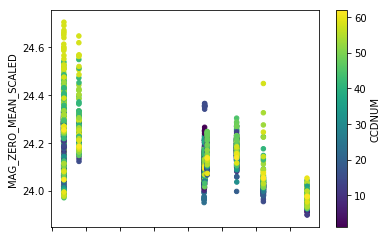

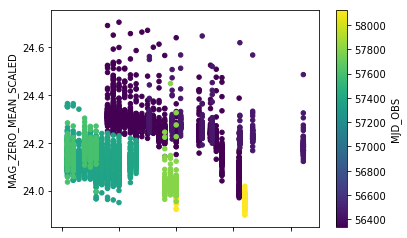

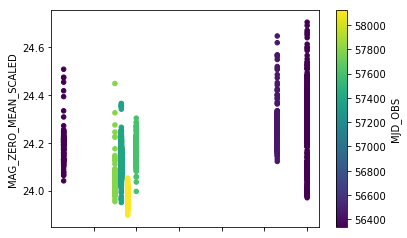

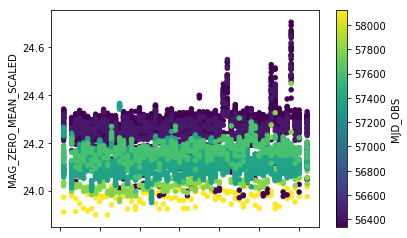

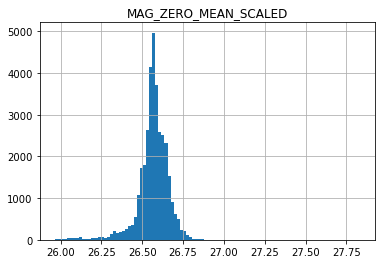

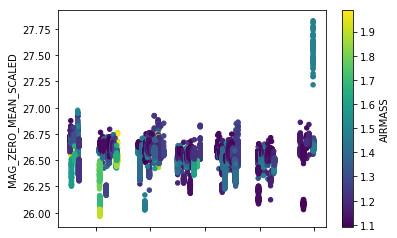

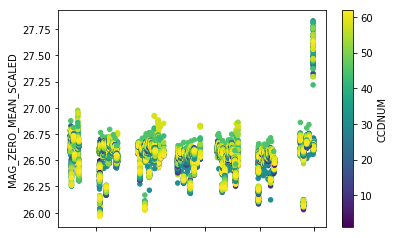

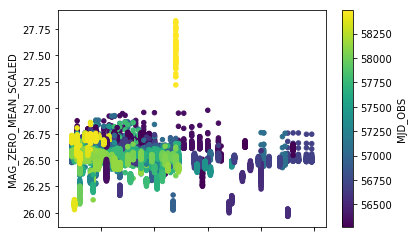

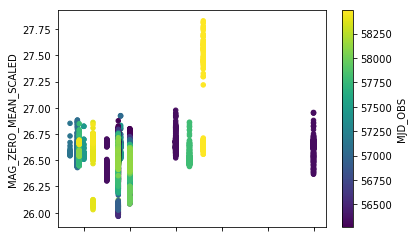

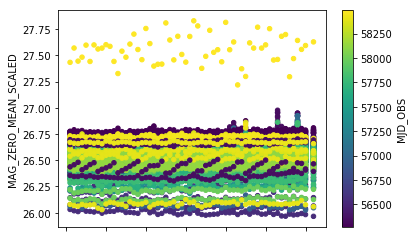

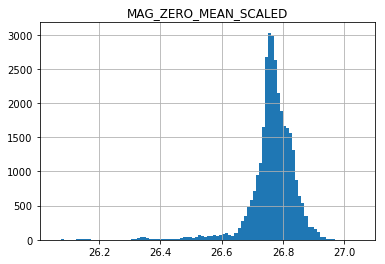

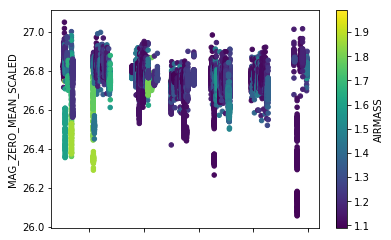

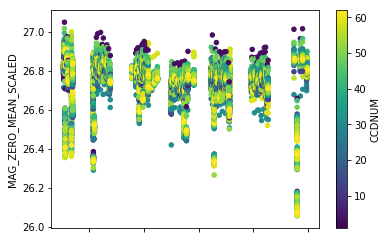

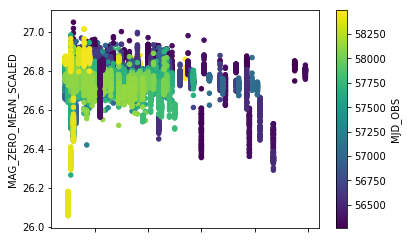

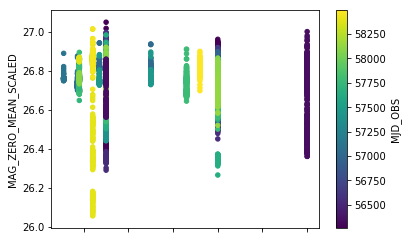

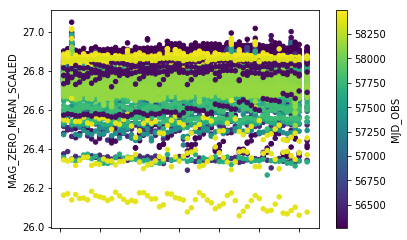

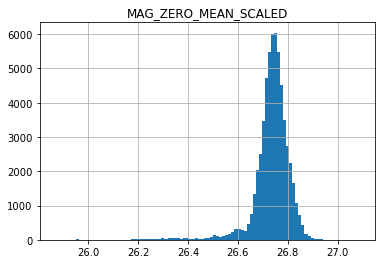

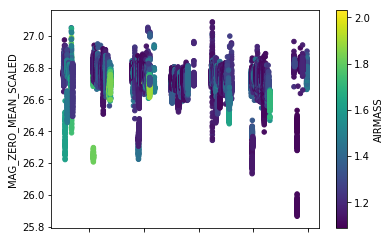

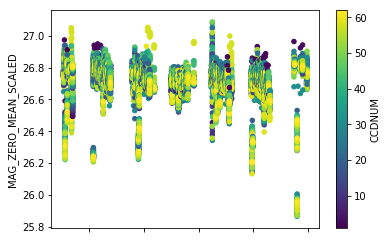

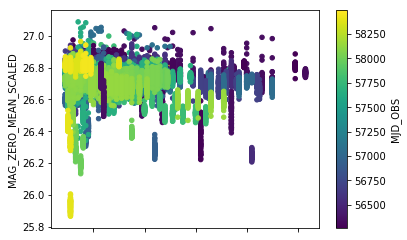

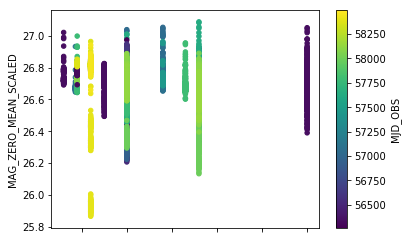

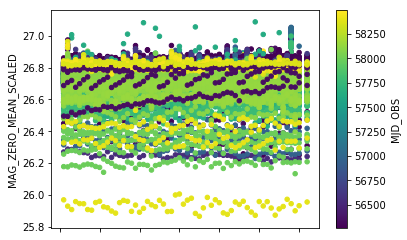

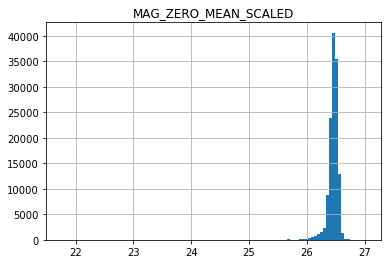

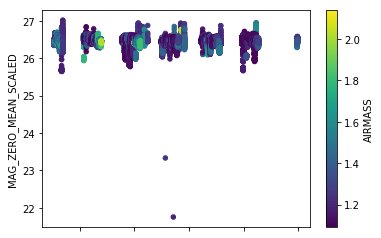

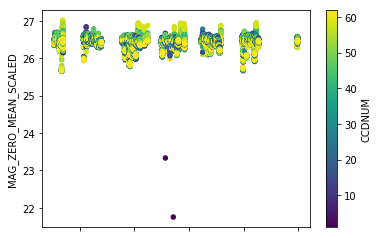

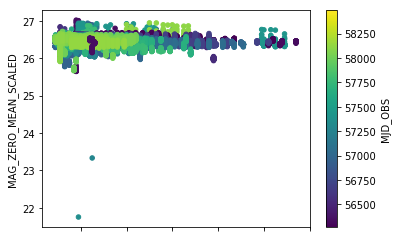

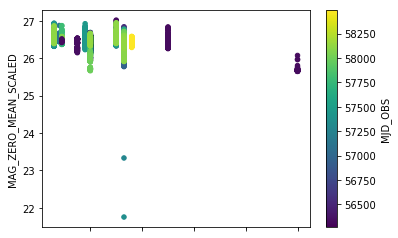

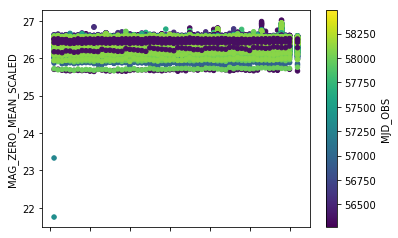

In [125]:
if do_qa_sdss_zps:
        
    subdir = """DES_%s""" % (tag_des)
    tmpdir = os.environ['TMPDIR']
    df_zp_collection = df_zp_collection_des
    
    for band in bandList:

        df_zp = df_zp_collection[band]
        
        df_zp['MAG_ZERO_MEAN_SCALED'] = df_zp['MAG_ZERO_MEAN'] - 2.5*np.log10(df_zp['EXPTIME'])
        
        df_zp.hist('MAG_ZERO_MEAN_SCALED', bins=100)
        df_zp.plot('MJD_OBS','MAG_ZERO_MEAN_SCALED','scatter', c='AIRMASS', cmap='viridis')
        df_zp.plot('MJD_OBS','MAG_ZERO_MEAN_SCALED','scatter', c='CCDNUM', cmap='viridis')
        df_zp.plot('AIRMASS','MAG_ZERO_MEAN_SCALED','scatter', c='MJD_OBS', cmap='viridis')
        df_zp.plot('EXPTIME','MAG_ZERO_MEAN_SCALED','scatter', c='MJD_OBS', cmap='viridis')
        df_zp.plot('CCDNUM','MAG_ZERO_MEAN_SCALED','scatter', c='MJD_OBS', cmap='viridis')

**DECADE:**

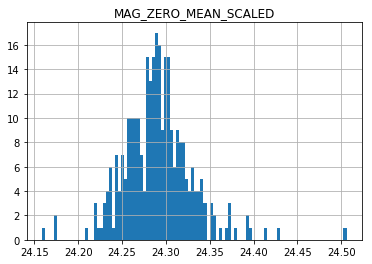

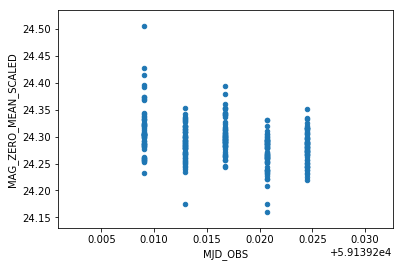

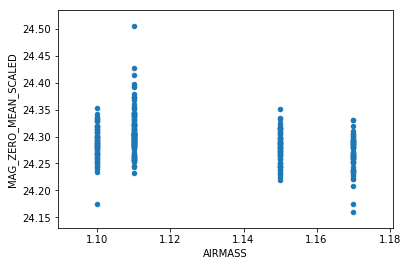

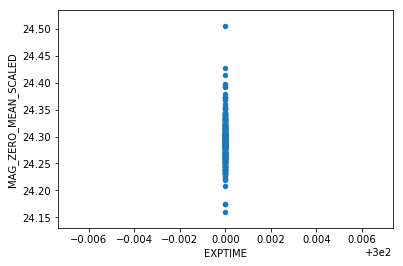

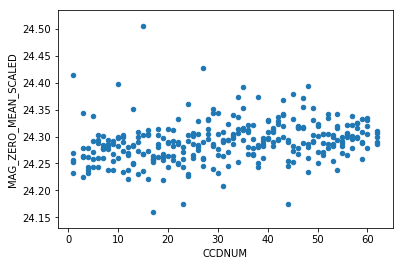

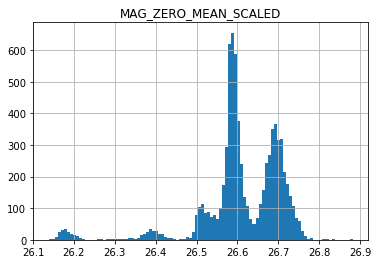

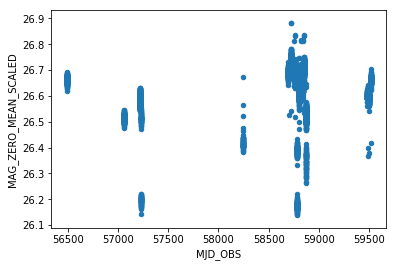

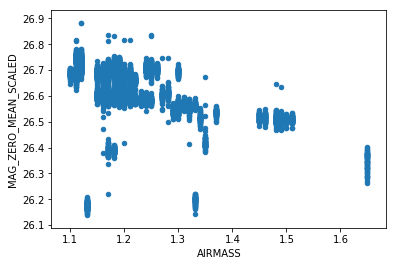

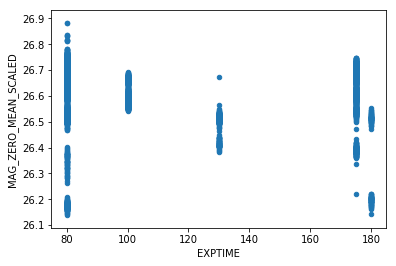

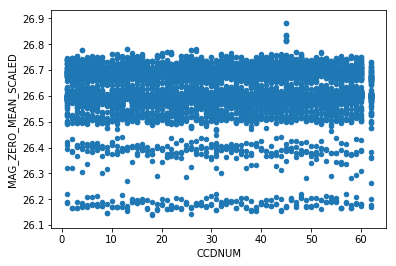

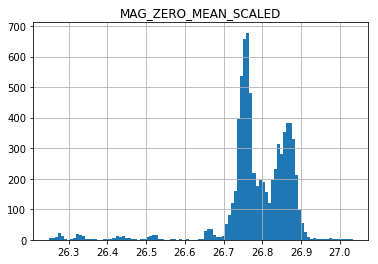

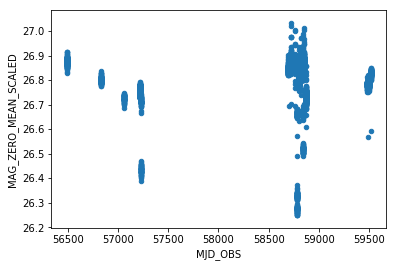

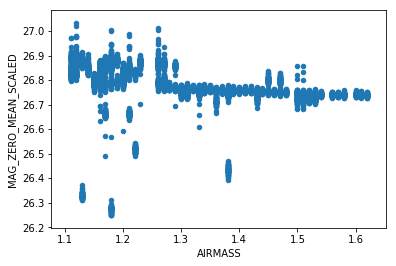

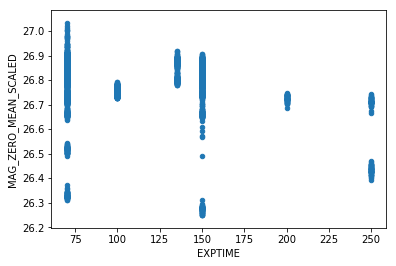

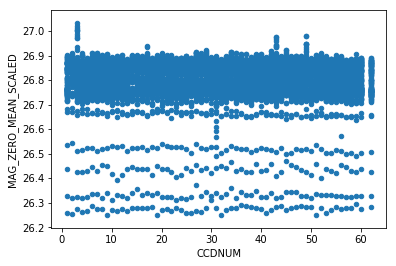

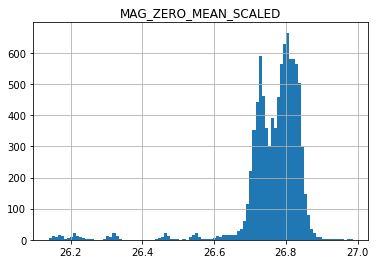

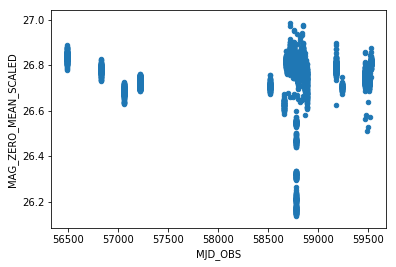

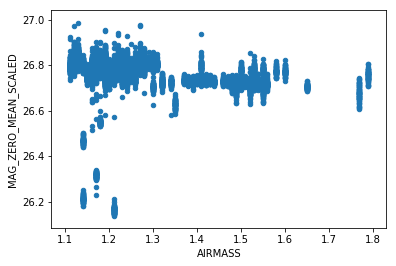

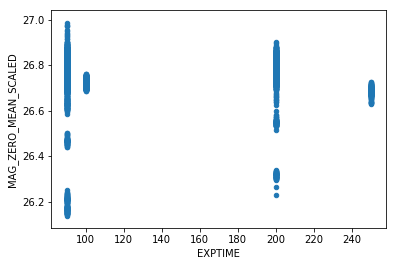

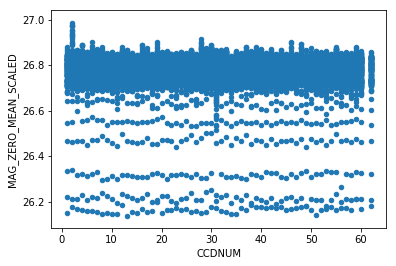

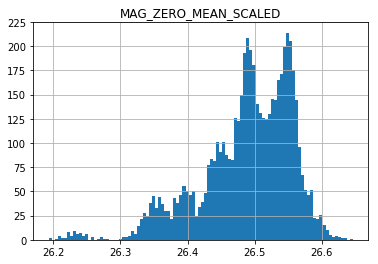

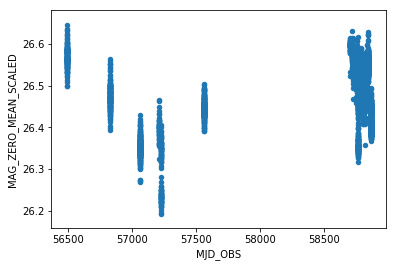

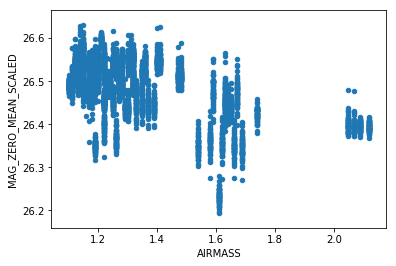

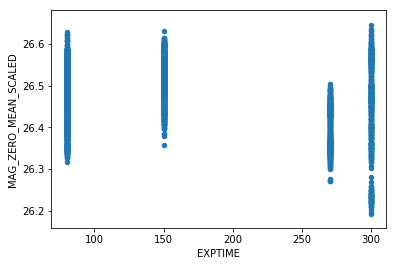

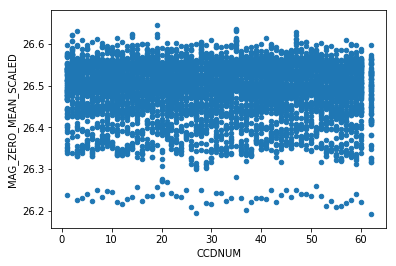

In [119]:
if do_qa_sdss_zps:
        
    subdir = """%s""" % (tag_des)
    tmpdir = os.environ['TMPDIR']
    df_zp_collection = df_zp_collection_decade
    
    for band in bandList:

        df_zp = df_zp_collection[band]
        
        df_zp['MAG_ZERO_MEAN_SCALED'] = df_zp['MAG_ZERO_MEAN'] - 2.5*np.log10(df_zp['EXPTIME'])
        
        df_zp.hist('MAG_ZERO_MEAN_SCALED', bins=100)
        df_zp.plot('MJD_OBS','MAG_ZERO_MEAN_SCALED','scatter')
        df_zp.plot('AIRMASS','MAG_ZERO_MEAN_SCALED','scatter')
        df_zp.plot('EXPTIME','MAG_ZERO_MEAN_SCALED','scatter')
        df_zp.plot('CCDNUM','MAG_ZERO_MEAN_SCALED','scatter')

In [16]:
band = 'g'
subdir = """DES_%s""" % (tag_des)
regionName = 'SN-S'

In [17]:
inputFile = """cat_%s.%s.0.%s.sdss.fits""" % (subdir, regionName, band)
inputFile = os.path.join(rawdata_dir, 'ExpCatFITS', subdir, inputFile)
#t = Table.read(inputFile)
#df = t.to_pandas()
#del t
#df
#t

np_cat = fitsio.read(inputFile, ext=1)
np_cat = np_cat.byteswap().newbyteorder()
df_cat = pd.DataFrame(np_cat)
df_cat

,EXPNUM,EXPRA,EXPDEC,EXPTIME,AIRMASS,BAND,NITE,MJD_OBS,FIELD,OBJECT,...,psfMagErr_u,psfMagErr_g,psfMagErr_r,psfMagErr_i,psfMagErr_z,run,stripe,GroupID,GroupSize,Separation
0,698806,41.117700,-0.991800,90.0,1.15,g,20171122,58080.151037,404-14,DES survey hex 404-14 tiling 9,...,0.009015,0.024407,0.014583,0.014639,0.013996,2820,82,-2147483648,-2147483648,0.160831
1,698806,41.117700,-0.991800,90.0,1.15,g,20171122,58080.151037,404-14,DES survey hex 404-14 tiling 9,...,0.026222,0.018220,0.011466,0.016161,0.015087,2820,82,-2147483648,-2147483648,0.084543
2,698806,41.117700,-0.991800,90.0,1.15,g,20171122,58080.151037,404-14,DES survey hex 404-14 tiling 9,...,0.050186,0.021016,0.020164,0.023535,0.013195,3388,82,-2147483648,-2147483648,0.441830
3,698806,41.117700,-0.991800,90.0,1.15,g,20171122,58080.151037,404-14,DES survey hex 404-14 tiling 9,...,0.036070,0.023385,0.026090,0.035153,0.111668,3388,82,-2147483648,-2147483648,0.052205
4,698806,41.117700,-0.991800,90.0,1.15,g,20171122,58080.151037,404-14,DES survey hex 404-14 tiling 9,...,0.030031,0.018429,0.011671,0.016328,0.016049,2820,82,-2147483648,-2147483648,0.008498
5,698806,41.117700,-0.991800,90.0,1.15,g,20171122,58080.151037,404-14,DES survey hex 404-14 tiling 9,...,0.156483,0.037060,0.042774,0.044456,0.155467,3388,82,-2147483648,-2147483648,0.099070
6,698806,41.117700,-0.991800,90.0,1.15,g,20171122,58080.151037,404-14,DES survey hex 404-14 tiling 9,...,0.145638,0.020550,0.012413,0.016476,0.015942,2820,82,-2147483648,-2147483648,0.288152
7,698806,41.117700,-0.991800,90.0,1.15,g,20171122,58080.151037,404-14,DES survey hex 404-14 tiling 9,...,0.189877,0.045914,0.052383,0.072150,0.167674,3388,82,-2147483648,-2147483648,0.034616
8,698806,41.117700,-0.991800,90.0,1.15,g,20171122,58080.151037,404-14,DES survey hex 404-14 tiling 9,...,0.194201,0.021977,0.012886,0.016929,0.018294,2820,82,-2147483648,-2147483648,0.129652
9,698806,41.117700,-0.991800,90.0,1.15,g,20171122,58080.151037,404-14,DES survey hex 404-14 tiling 9,...,0.061642,0.021109,0.020188,0.023521,0.013024,3388,82,-2147483648,-2147483648,0.884220


In [18]:
zpFile = """zps_%s.%s.sdss.csv""" % (subdir, band)
zpFile = os.path.join(zeropoints_dir, zpFile)
df_zp = pd.read_csv(zpFile, usecols=['FILENAME','MAG_ZERO_MEAN','MAG_ZERO_MEAN_ERR','MAG_ZERO_NUM'])
df_zp

,FILENAME,MAG_ZERO_MEAN,MAG_ZERO_MEAN_ERR,MAG_ZERO_NUM
0,D00573106_g_c01_r3624p01_red-fullcat.fits,31.5385,0.0034,29.0
1,D00573106_g_c03_r3624p01_red-fullcat.fits,31.5246,0.0040,58.0
2,D00573106_g_c04_r3624p01_red-fullcat.fits,31.5024,0.0051,40.0
3,D00573106_g_c05_r3624p01_red-fullcat.fits,31.5203,0.0035,39.0
4,D00573106_g_c06_r3624p01_red-fullcat.fits,31.5133,0.0066,35.0
5,D00573106_g_c07_r3624p01_red-fullcat.fits,31.5058,0.0043,36.0
6,D00573106_g_c08_r3624p01_red-fullcat.fits,31.5058,0.0046,38.0
7,D00573106_g_c09_r3624p01_red-fullcat.fits,31.4919,0.0050,46.0
8,D00573106_g_c10_r3624p01_red-fullcat.fits,31.5008,0.0042,34.0
9,D00573106_g_c11_r3624p01_red-fullcat.fits,31.5335,0.0042,49.0


In [19]:
df_merged = pd.merge(df_zp, df_cat, \
                            on=['FILENAME'], \
                            how='right', \
                            suffixes=('','_yyy')).reset_index(drop=True)

# Remove any redundant columns...
to_drop = [colname for colname in df_merged if colname.endswith('_yyy')]
df_merged.drop(to_drop, axis=1, inplace=True)

df_merged

,FILENAME,MAG_ZERO_MEAN,MAG_ZERO_MEAN_ERR,MAG_ZERO_NUM,EXPNUM,EXPRA,EXPDEC,EXPTIME,AIRMASS,BAND,...,psfMagErr_u,psfMagErr_g,psfMagErr_r,psfMagErr_i,psfMagErr_z,run,stripe,GroupID,GroupSize,Separation
0,D00157474_g_c01_r3727p01_red-fullcat.fits,32.2848,0.0109,16.0,157474,42.820000,0.0000,175.0,1.16,g,...,0.016718,0.022626,0.016771,0.015544,0.018160,7717,81,3263,56,0.069877
1,D00157474_g_c01_r3727p01_red-fullcat.fits,32.2848,0.0109,16.0,157474,42.820000,0.0000,175.0,1.16,g,...,0.048454,0.024468,0.016650,0.017315,0.032582,7717,81,3381,15,0.118879
2,D00157474_g_c01_r3727p01_red-fullcat.fits,32.2848,0.0109,16.0,157474,42.820000,0.0000,175.0,1.16,g,...,0.069927,0.031145,0.027504,0.031713,0.094475,7717,81,3408,61,0.087162
3,D00157474_g_c01_r3727p01_red-fullcat.fits,32.2848,0.0109,16.0,157474,42.820000,0.0000,175.0,1.16,g,...,0.066365,0.019254,0.018928,0.022233,0.054618,7675,81,3410,61,0.042193
4,D00157474_g_c01_r3727p01_red-fullcat.fits,32.2848,0.0109,16.0,157474,42.820000,0.0000,175.0,1.16,g,...,0.032584,0.023069,0.015032,0.015043,0.018112,7717,81,3481,63,0.084335
5,D00157474_g_c01_r3727p01_red-fullcat.fits,32.2848,0.0109,16.0,157474,42.820000,0.0000,175.0,1.16,g,...,0.015791,0.022338,0.014318,0.014265,0.013679,7717,81,3510,63,0.088733
6,D00157474_g_c01_r3727p01_red-fullcat.fits,32.2848,0.0109,16.0,157474,42.820000,0.0000,175.0,1.16,g,...,0.158599,0.047226,0.039392,0.046479,0.160806,7717,81,3517,49,0.108084
7,D00157474_g_c01_r3727p01_red-fullcat.fits,32.2848,0.0109,16.0,157474,42.820000,0.0000,175.0,1.16,g,...,0.108997,0.026396,0.017476,0.017757,0.032022,7717,81,3525,62,0.070216
8,D00157474_g_c01_r3727p01_red-fullcat.fits,32.2848,0.0109,16.0,157474,42.820000,0.0000,175.0,1.16,g,...,0.165261,0.038826,0.033574,0.043459,0.149000,7717,81,3549,63,0.133780
9,D00157474_g_c01_r3727p01_red-fullcat.fits,32.2848,0.0109,16.0,157474,42.820000,0.0000,175.0,1.16,g,...,0.028613,0.013234,0.013758,0.015857,0.024258,7675,81,3568,60,0.076543


In [57]:
df_merged['MAG_ZERO_MEAN_SCALED'] = df_merged['MAG_ZERO_MEAN'] - 2.5*np.log10(df_merged['EXPTIME'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2b472dc6ca90>]],
      dtype=object)

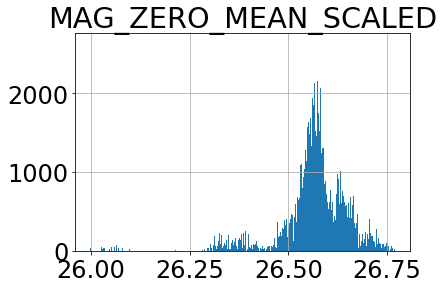

In [58]:
df_merged.hist('MAG_ZERO_MEAN_SCALED', bins=1000)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2b4740797e10>]],
      dtype=object)

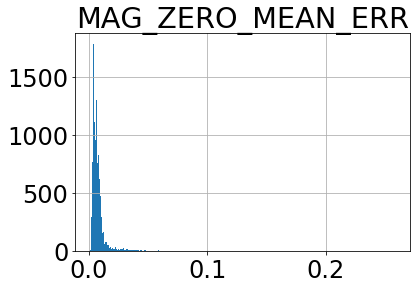

In [56]:
df_zp.hist('MAG_ZERO_MEAN_ERR', bins=1000)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2b472883eed0>]],
      dtype=object)

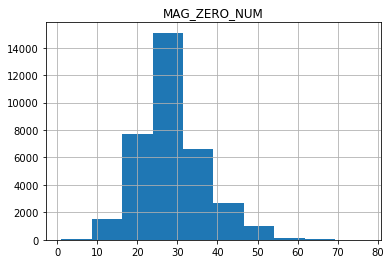

In [22]:
df_zp.hist('MAG_ZERO_NUM')

In [23]:
fluxObsColName =    'FLUX_PSF' 
fluxerrObsColName = 'FLUXERR_PSF' 


magStdColName = """%s_sdss_des""" % (band)
magerrStdColName = """%serr_sdss_des""" % (band)
print magStdColName, magerrStdColName

g_sdss_des gerr_sdss_des


In [24]:
df_merged = transSDSStoDES(df_merged, band, magStdColName, magerrStdColName)

In [25]:
df_merged

,FILENAME,MAG_ZERO_MEAN,MAG_ZERO_MEAN_ERR,MAG_ZERO_NUM,EXPNUM,EXPRA,EXPDEC,EXPTIME,AIRMASS,BAND,...,psfMagErr_r,psfMagErr_i,psfMagErr_z,run,stripe,GroupID,GroupSize,Separation,g_sdss_des,gerr_sdss_des
0,D00157474_g_c01_r3727p01_red-fullcat.fits,32.2848,0.0109,16.0,157474,42.820000,0.0000,175.0,1.16,g,...,0.016771,0.015544,0.018160,7717,81,3263,56,0.069877,16.664419,0.022626
1,D00157474_g_c01_r3727p01_red-fullcat.fits,32.2848,0.0109,16.0,157474,42.820000,0.0000,175.0,1.16,g,...,0.016650,0.017315,0.032582,7717,81,3381,15,0.118879,19.383203,0.024468
2,D00157474_g_c01_r3727p01_red-fullcat.fits,32.2848,0.0109,16.0,157474,42.820000,0.0000,175.0,1.16,g,...,0.027504,0.031713,0.094475,7717,81,3408,61,0.087162,20.570102,0.031145
3,D00157474_g_c01_r3727p01_red-fullcat.fits,32.2848,0.0109,16.0,157474,42.820000,0.0000,175.0,1.16,g,...,0.018928,0.022233,0.054618,7675,81,3410,61,0.042193,20.058688,0.019254
4,D00157474_g_c01_r3727p01_red-fullcat.fits,32.2848,0.0109,16.0,157474,42.820000,0.0000,175.0,1.16,g,...,0.015032,0.015043,0.018112,7717,81,3481,63,0.084335,18.478018,0.023069
5,D00157474_g_c01_r3727p01_red-fullcat.fits,32.2848,0.0109,16.0,157474,42.820000,0.0000,175.0,1.16,g,...,0.014318,0.014265,0.013679,7717,81,3510,63,0.088733,16.415372,0.022338
6,D00157474_g_c01_r3727p01_red-fullcat.fits,32.2848,0.0109,16.0,157474,42.820000,0.0000,175.0,1.16,g,...,0.039392,0.046479,0.160806,7717,81,3517,49,0.108084,21.432020,0.047226
7,D00157474_g_c01_r3727p01_red-fullcat.fits,32.2848,0.0109,16.0,157474,42.820000,0.0000,175.0,1.16,g,...,0.017476,0.017757,0.032022,7717,81,3525,62,0.070216,19.968290,0.026396
8,D00157474_g_c01_r3727p01_red-fullcat.fits,32.2848,0.0109,16.0,157474,42.820000,0.0000,175.0,1.16,g,...,0.033574,0.043459,0.149000,7717,81,3549,63,0.133780,21.095338,0.038826
9,D00157474_g_c01_r3727p01_red-fullcat.fits,32.2848,0.0109,16.0,157474,42.820000,0.0000,175.0,1.16,g,...,0.013758,0.015857,0.024258,7675,81,3568,60,0.076543,18.246149,0.013234


In [26]:
## Transform SDSS mags to DES mags for the given band...
#dataFrame = transSDSStoDES(dataFrame, band, magStdColName, magerrStdColName)

# Add a 'MAG_OBS' column and a 'MAG_DIFF' column to the pandas DataFrame...
df_merged['MAG_OBS'] = -2.5*np.log10(df_merged[fluxObsColName]) + df_merged['MAG_ZERO_MEAN']
df_merged['MAG_DIFF'] = df_merged[magStdColName]-df_merged['MAG_OBS']

df_merged.head(10)

,FILENAME,MAG_ZERO_MEAN,MAG_ZERO_MEAN_ERR,MAG_ZERO_NUM,EXPNUM,EXPRA,EXPDEC,EXPTIME,AIRMASS,BAND,...,psfMagErr_z,run,stripe,GroupID,GroupSize,Separation,g_sdss_des,gerr_sdss_des,MAG_OBS,MAG_DIFF
0,D00157474_g_c01_r3727p01_red-fullcat.fits,32.2848,0.0109,16.0,157474,42.82,0.0,175.0,1.16,g,...,0.018160,7717,81,3263,56,0.069877,16.664419,0.022626,16.633631,0.030788
1,D00157474_g_c01_r3727p01_red-fullcat.fits,32.2848,0.0109,16.0,157474,42.82,0.0,175.0,1.16,g,...,0.032582,7717,81,3381,15,0.118879,19.383203,0.024468,19.370713,0.012489
2,D00157474_g_c01_r3727p01_red-fullcat.fits,32.2848,0.0109,16.0,157474,42.82,0.0,175.0,1.16,g,...,0.094475,7717,81,3408,61,0.087162,20.570102,0.031145,20.924368,-0.354266
3,D00157474_g_c01_r3727p01_red-fullcat.fits,32.2848,0.0109,16.0,157474,42.82,0.0,175.0,1.16,g,...,0.054618,7675,81,3410,61,0.042193,20.058688,0.019254,20.073780,-0.015092
4,D00157474_g_c01_r3727p01_red-fullcat.fits,32.2848,0.0109,16.0,157474,42.82,0.0,175.0,1.16,g,...,0.018112,7717,81,3481,63,0.084335,18.478018,0.023069,18.481350,-0.003333
5,D00157474_g_c01_r3727p01_red-fullcat.fits,32.2848,0.0109,16.0,157474,42.82,0.0,175.0,1.16,g,...,0.013679,7717,81,3510,63,0.088733,16.415372,0.022338,16.392368,0.023004
6,D00157474_g_c01_r3727p01_red-fullcat.fits,32.2848,0.0109,16.0,157474,42.82,0.0,175.0,1.16,g,...,0.160806,7717,81,3517,49,0.108084,21.432020,0.047226,21.344629,0.087391
7,D00157474_g_c01_r3727p01_red-fullcat.fits,32.2848,0.0109,16.0,157474,42.82,0.0,175.0,1.16,g,...,0.032022,7717,81,3525,62,0.070216,19.968290,0.026396,19.905346,0.062945
8,D00157474_g_c01_r3727p01_red-fullcat.fits,32.2848,0.0109,16.0,157474,42.82,0.0,175.0,1.16,g,...,0.149000,7717,81,3549,63,0.133780,21.095338,0.038826,21.074265,0.021073
9,D00157474_g_c01_r3727p01_red-fullcat.fits,32.2848,0.0109,16.0,157474,42.82,0.0,175.0,1.16,g,...,0.024258,7675,81,3568,60,0.076543,18.246149,0.013234,18.266654,-0.020505


(-0.1, 0.1)

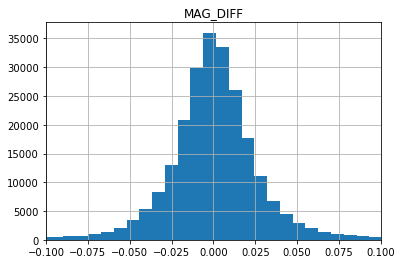

In [27]:
df_merged.hist('MAG_DIFF', bins=1000)
plt.xlim([-0.1,0.1])

0

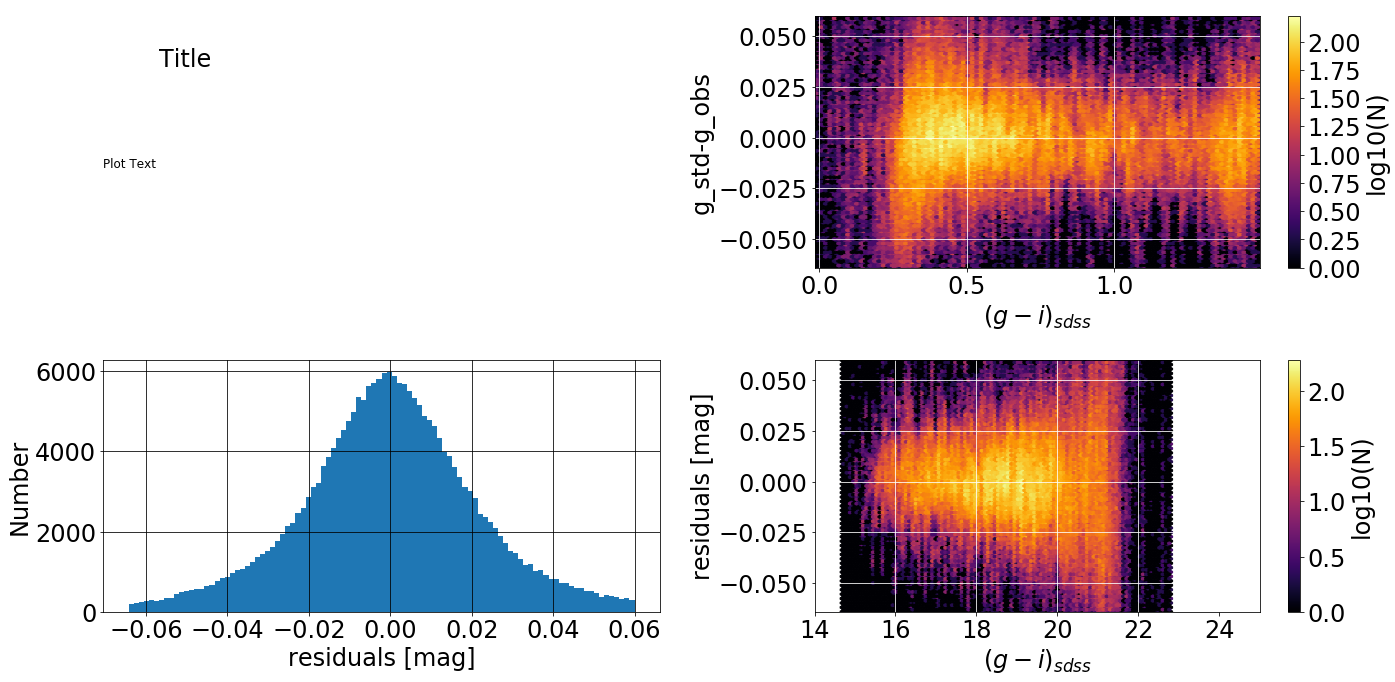

In [55]:
dmag = df_merged['MAG_DIFF']
res = df_merged['MAG_DIFF']
color1 = df_merged['psfMag_g'] - df_merged['psfMag_r']
title = 'Title'
plotText = 'Plot Text'
dmagName = """%s_std-%s_obs""" % (band, band)
colorLabel1 = colorLabel_1_dict[band]
outputFileName = 'test.png'
sdssQAPlots(df_merged, title, plotText, dmagName, colorLabel1, outputFileName)


Calculate zeropoints region by region...

In [ ]:
%%time 

if do_qa_sdss_zps: 
    
    fluxObsColName =    'FLUX_PSF' 
    fluxerrObsColName = 'FLUXERR_PSF' 
    aggFieldColName =   'FILENAME' 
    
    subdir = """DES_%s""" % (tag_des)

    tmpdir = os.environ['TMPDIR']


    for regionName in region_name_list:
    
        print
        print """# # # # # # # # # # # # # # #"""
        print """Working on region %s""" % (regionName)
        print """# # # # # # # # # # # # # # #"""
        print
        
        for band in bandList:
                    
            input_file_template = """cat_%s.%s.?.%s.sdss.fits""" % (subdir, regionName, band)
            input_file_template = os.path.join(rawdata_dir, 'ExpCatFITS', subdir, input_file_template)
            input_file_list = glob.glob(input_file_template)
            input_file_list = np.sort(input_file_list)

            if np.size(input_file_list) == 0:
                print "No files matching template %s" % (input_file_template)
    
            for inputFile in input_file_list:
            
                print inputFile 

                if os.path.exists(inputFile):

                    #outputFile = os.path.splitext(inputFile)[0] + '.zps.csv'
                    #print outputFile
                    
                    outputFile = os.path.splitext(os.path.basename(inputFile))[0]+'.csv'
                    outputFile = 'zps_' + outputFile[4:]
                    outputFile = os.path.join(zeropoints_dir, outputFile)

                    print outputFile    

                    status = DECam_tie_to_sdss(inputFile, outputFile, 
                                                    band, 
                                                    fluxObsColName, fluxerrObsColName, 
                                                    aggFieldColName, verbose)
                    if status > 0:
                        print 'ERROR:  %s FAILED!  Continuing...'
            
                else:
            
                    print """%s does not exist...  skipping...""" % (inputFile)
                
                print

Combine region-by-region results into a single file...

In [ ]:
%%time 

if do_calc_sdss_zps: 
        
    subdir = """DES_%s""" % (tag_des)

    tmpdir = os.environ['TMPDIR']

    
    for band in bandList:
                    
        print
        print """# # # # # # # # # # # # # # #"""
        print """Working on band %s""" % (band)
        print """# # # # # # # # # # # # # # #"""
        print

        outputFile = """zps_%s.%s.sdss.csv""" % (subdir, band)
        outputFile = outputFile = os.path.join(zeropoints_dir, outputFile)
    
        input_file_template = """zps_%s.*.?.%s.sdss.csv""" % (subdir, band)
        input_file_template = os.path.join(zeropoints_dir, input_file_template)
        input_file_list = glob.glob(input_file_template)
        input_file_list = np.sort(input_file_list)

        if np.size(input_file_list) == 0:
            print "No files matching template %s" % (input_file_template)
            continue
    
        df_comb = pd.concat(pd.read_csv(inputFile) for inputFile in input_file_list)

        outputFile = """zps_%s.%s.sdss.csv""" % (subdir, band)
        outputFile = outputFile = os.path.join(zeropoints_dir, outputFile)
        print outputFile
        df_comb.to_csv(outputFile, index=False)
        
        del df_comb


**DECADE:**

Calculate zeropoints region by region...

In [ ]:
%%time 

if do_calc_sdss_zps: 
    
    fluxObsColName =    'FLUX_PSF' 
    fluxerrObsColName = 'FLUXERR_PSF' 
    aggFieldColName =   'FILENAME' 
    
    subdir = """%s""" % (tag_decade)

    tmpdir = os.environ['TMPDIR']


    for regionName in region_name_list:
    
        print
        print """# # # # # # # # # # # # # # #"""
        print """Working on region %s""" % (regionName)
        print """# # # # # # # # # # # # # # #"""
        print
        
        for band in bandList:
                    
            input_file_template = """cat_%s.%s.?.%s.sdss.fits""" % (subdir, regionName, band)
            input_file_template = os.path.join(rawdata_dir, 'ExpCatFITS', subdir, input_file_template)
            input_file_list = glob.glob(input_file_template)
            input_file_list = np.sort(input_file_list)

            if np.size(input_file_list) == 0:
                print "No files matching template %s" % (input_file_template)
    
            for inputFile in input_file_list:
            
                print inputFile 

                if os.path.exists(inputFile):

                    #outputFile = os.path.splitext(inputFile)[0] + '.zps.csv'
                    #print outputFile
                    
                    outputFile = os.path.splitext(os.path.basename(inputFile))[0]+'.csv'
                    outputFile = 'zps_' + outputFile[4:]
                    outputFile = os.path.join(zeropoints_dir, outputFile)

                    print outputFile    

                    status = DECam_tie_to_sdss(inputFile, outputFile, 
                                                    band, 
                                                    fluxObsColName, fluxerrObsColName, 
                                                    aggFieldColName, verbose)
                    if status > 0:
                        print 'ERROR:  %s FAILED!  Continuing...'
            
                else:
            
                    print """%s does not exist...  skipping...""" % (inputFile)
                
                print

Combine region-by-region results into a single file...

In [ ]:
%%time 

if do_calc_sdss_zps: 
        
    subdir = """%s""" % (tag_decade)

    tmpdir = os.environ['TMPDIR']

    
    for band in bandList:
                    
        print
        print """# # # # # # # # # # # # # # #"""
        print """Working on band %s""" % (band)
        print """# # # # # # # # # # # # # # #"""
        print

        outputFile = """zps_%s.%s.sdss.csv""" % (subdir, band)
        outputFile = outputFile = os.path.join(zeropoints_dir, outputFile)
    
        input_file_template = """zps_%s.*.?.%s.sdss.csv""" % (subdir, band)
        input_file_template = os.path.join(zeropoints_dir, input_file_template)
        input_file_list = glob.glob(input_file_template)
        input_file_list = np.sort(input_file_list)

        if np.size(input_file_list) == 0:
            print "No files matching template %s" % (input_file_template)
            continue
    
        df_comb = pd.concat(pd.read_csv(inputFile) for inputFile in input_file_list)

        outputFile = """zps_%s.%s.sdss.csv""" % (subdir, band)
        outputFile = outputFile = os.path.join(zeropoints_dir, outputFile)
        print outputFile
        df_comb.to_csv(outputFile, index=False)
        
        del df_comb
